In [1]:
from astroquery.vizier import Vizier
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
import pandas as pd
import os
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import time
#import seaborn as sns
%matplotlib inline

The USNO-B catalog is "I/284" 

In [2]:
data=Table.read("/Users/kschles/Documents/GALAH/HVS/update_08112015/sobject_iraf_general.fits")

In [3]:
data=data.to_pandas()

In [4]:
#Output smaller file to use to query USNO via STILTS and TAP
data[['sobject_id', 'ra', 'dec']].to_csv('propermotion_temp.csv', index=False)

In [ ]:
### Want to find all matches in USNO-B within 7" of the target
os.system('java -jar stilts.jar cdsskymatch cdstable=I/284/out find=all in=propermotion_temp.csv ifmt=csv ra=ra dec=dec radius=7 out=usnob_7as.csv')

In [7]:
## Read in the 7" radius query and use it to identify nearest neighbors and matches. 
usnob=pd.read_csv('/Users/kschles/Documents/GALAH/propermotion/usnob_7as.csv')

In [8]:
usnob.loc[np.where(usnob['angDist']<=1.0)[0], 'match']=1
usnob.loc[np.where(((usnob['Bmag1']<22.) | (usnob['Bmag2']<22.)) & (usnob['angDist']>1.0))[0], 'neighbor']=1

In [9]:
test=usnob.groupby(['COB_ID', 'PIVOT'])

In [10]:
prelim_quality=test.agg({'COB_ID': 'first', 'PIVOT': 'first', 'match' : np.sum, 'neighbor' : np.sum, 'angDist' : lambda x: min(x)})

In [11]:
combo1=pd.merge(data, prelim_quality[['COB_ID', 'PIVOT', 'match', 'neighbor']], on=['COB_ID', 'PIVOT'], how='left')

In [31]:
# Need to make a loop to query the usno-b catalog using tap because has issues with searches greater than 1750 items. 

usno_index=np.append([np.arange(0,len(data),1750)],[len(data)-1])
for j in range(1,len(usno_index)) :
    print usno_index[j-1], time.ctime()
    if (j!=1):
        data.loc[usno_index[j-1]+1:usno_index[j],['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']].to_csv('propermotion_temp.csv', index=False)
    if (j==1): 
        data.loc[usno_index[j-1]:usno_index[j],['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']].to_csv('propermotion_temp.csv', index=False)
    temp=os.system('java -jar stilts.jar tapskymatch tapurl=http://dc.g-vo.org/tap taptable=usnob.data in=propermotion_temp.csv ifmt=csv inlon=RADEG inlat=DEDEG out=usnob_2as_temp.csv taplon=RAJ2000 taplat=DEJ2000 sr=0.00050 find=each') 
    os.system('mv usnob_2as_temp.csv usnob_output/usnob_2as_'+str(j)+'.csv')


0 Wed May  4 14:17:21 2016
1750 Wed May  4 14:17:28 2016
3500 Wed May  4 14:17:34 2016
5250 Wed May  4 14:17:41 2016
7000 Wed May  4 14:17:48 2016
8750 Wed May  4 14:17:54 2016
10500 Wed May  4 14:18:01 2016
12250 Wed May  4 14:18:11 2016
14000 Wed May  4 14:18:18 2016
15750 Wed May  4 14:18:25 2016
17500 Wed May  4 14:18:32 2016
19250 Wed May  4 14:18:39 2016
21000 Wed May  4 14:18:46 2016
22750 Wed May  4 14:18:52 2016
24500 Wed May  4 14:18:59 2016
26250 Wed May  4 14:19:06 2016
28000 Wed May  4 14:19:13 2016
29750 Wed May  4 14:19:19 2016
31500 Wed May  4 14:19:26 2016
33250 Wed May  4 14:19:33 2016
35000 Wed May  4 14:19:40 2016
36750 Wed May  4 14:19:47 2016
38500 Wed May  4 14:19:54 2016
40250 Wed May  4 14:20:01 2016
42000 Wed May  4 14:20:08 2016
43750 Wed May  4 14:20:15 2016
45500 Wed May  4 14:20:23 2016
47250 Wed May  4 14:20:30 2016
49000 Wed May  4 14:20:38 2016
50750 Wed May  4 14:20:45 2016
52500 Wed May  4 14:20:52 2016
54250 Wed May  4 14:20:58 2016
56000 Wed May  4 

KeyError: 'stop bound [260677] is not in the [index]'

In [39]:
# Read in and combine the USNO-B files created using TAP
for j in range(1,len(usno_index)) :
    filename='usnob_output/usnob_2as_'+str(j)+'.csv'
    temp=pd.read_csv(filename)
    if j==1: 
        usnob_best=temp
    if j>1: 
        usnob_best=pd.concat([usnob_best, temp])

In [42]:
## Merge teh USNO-B data with the rest
combo=pd.merge(combo1,usnob_best[['COB_ID', 'PIVOT', 'fit_ra', 'fit_de', 'ndet', 'sep_arcsec']],\
                            on=['COB_ID', 'PIVOT'], how='left')

In [56]:
# There should be no rows here! 
combo.loc[np.where((combo['match']>=1) & (np.isnan(combo['ndet'])==True))[0],\
                   ['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']]

,COB_ID,PIVOT,RADEG,DEDEG


In [62]:
print combo.columns.values
#Adjust the fit_RA and fit_DE values from degrees to mas
combo['fit_ra']=np.round(combo['fit_ra']*3600.*1000.)
combo['fit_de']=np.round(combo['fit_de']*3600.*1000.)


['COB_ID' 'PIVOT' 'DIRNAME' 'GALAH_ID' 'COMBINE_METHOD' 'RADEG' 'DEDEG'
 'GLON' 'GLAT' 'CFG_FILE' 'CENRA' 'CENDEC' 'OBJECT_NAME' 'COMMENT' 'EBV'
 'TEFF_GUESS' 'LOGG_GUESS' 'FEH_GUESS' 'RV_CCD1' 'RV_CCD2' 'RV_CCD3'
 'RV_MEAN' 'RV_STDDEV' 'FLAG_GUESS' 'SNR_ERROR_CCD1' 'SNR_ERROR_CCD2'
 'SNR_ERROR_CCD3' 'SNR_ERROR_CCD4' 'SNR_GUESS_CCD1' 'SNR_GUESS_CCD2'
 'SNR_GUESS_CCD3' 'SNR_GUESS_CCD4' '2MASS_ID' 'JMAG' 'E_JMAG' 'HMAG'
 'E_HMAG' 'KMAG' 'E_KMAG' '2MASS_QFL' '2MASS_RFL' '2MASS_XFL' 'BMAG'
 'E_BMAG' 'VMAG' 'E_VMAG' 'GPMAG' 'E_GPMAG' 'RPMAG' 'E_RPMAG' 'IPMAG'
 'E_IPMAG' 'UCAC4_ID' 'PMRA' 'E_PMRA' 'PMDE' 'E_PMDE' 'match' 'neighbor'
 'fit_ra' 'fit_de' 'ndet' 'sep_arcsec' 'fit_dec']


In [55]:
combo.to_csv('propermotion_quality_05042016.csv', index=False)

In [54]:
len(combo), len(combo1)

(260825, 260677)

In [49]:
test=combo.groupby(['COB_ID', 'PIVOT']).agg('count')

In [53]:
np.where(test['GALAH_ID']!=1)

(array([  1750,   3500,   5250,   7000,   8750,  10500,  12250,  14000,
         15750,  17500,  19250,  21000,  22750,  24500,  26250,  28000,
         29750,  31500,  33250,  35000,  36750,  38500,  40250,  42000,
         43750,  45500,  47250,  49000,  50750,  52500,  54250,  56000,
         57750,  59500,  61250,  63000,  64750,  66500,  68250,  70000,
         71750,  73500,  75250,  77000,  78750,  80500,  82250,  84000,
         85750,  87500,  89250,  91000,  92750,  94500,  96250,  98000,
         99750, 101500, 103250, 105000, 106750, 108500, 110250, 112000,
        113750, 115500, 117250, 119000, 120750, 122500, 124250, 126000,
        127750, 129500, 131250, 133000, 134750, 136500, 138250, 140000,
        141750, 143500, 145250, 147000, 148750, 150500, 152250, 154000,
        155750, 157500, 159250, 161000, 162750, 164500, 166250, 168000,
        169750, 171500, 173250, 175000, 176750, 178500, 180250, 182000,
        183750, 185500, 187250, 189000, 190750, 192500, 194250, 

In [40]:
len(usnob_best)

260825

In [14]:
count=1
mv=len(np.where((combo_temp['match']>=1) & (np.isnan(combo_temp['ndet'])==True))[0])
if (mv>0) :
    # output the info for the missing values
    combo_temp.loc[np.where((combo_temp['match']>=1) & (np.isnan(combo_temp['ndet'])==True))[0],\
                   ['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']].to_csv('missing_values_temp.csv', index=False)
    # rerun the TAP query to find matches for the missing values
    #temp=os.system('java -jar stilts.jar tapskymatch tapurl=http://dc.g-vo.org/tap taptable=usnob.data in=missing_values_temp.csv ifmt=csv inlon=RADEG inlat=DEDEG out=usnob_mv_temp.csv taplon=RAJ2000 taplat=DEJ2000 sr=0.00050 find=all') 
    if (temp==0): #once the query has run successfully...
        usnob_temp=pd.read_csv('/Users/kschles/Documents/GALAH/propermotion/usnob_mv_temp.csv')
        os.system('mv usnob_mv_temp usnob_mv'+str(count)+'.csv')
        usnob_best_temp=pd.concat([usnob_best_combined, usnob_temp])
        usnob_best_combined=usnob_best_temp
        combo_temp=pd.merge(combo1,usnob_best_combined[['COB_ID', 'PIVOT', 'fit_ra', 'fit_de', 'ndet', 'sep_arcsec']],\
                            on=['COB_ID', 'PIVOT'], how='left')
        count+=1
        
        


NameError: name 'temp' is not defined

In [35]:
len(np.where((combo_temp['match']>=1) & (np.isnan(combo_temp['ndet'])==True))[0])

90006

In [40]:
count=1
print 'mv usnob_mv_temp usnob_mv'+str(count)+'.csv'
os.system('mv usnob_mv_temp usnob_mv'+str(count)+'.csv')

mv usnob_mv_temp usnob_mv1.csv


256

In [22]:
## Output a file that lists all the targets that SHOULD have a match in the usnob_2as data but don't due to 
## query truncation. 
combo_temp.loc[np.where((combo_temp['match']>=1) & (np.isnan(combo_temp['ndet'])==True))[0],['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']].to_csv('missing_values1.csv', index=False)

In [16]:
## Rerun the TAP query to find matches for the missing values
### Also want detailed information from USNO-B for the best 1" match for each target. (fitRA, fitDEC, nFit, etc.)
os.system('java -jar stilts.jar tapskymatch tapurl=http://dc.g-vo.org/tap taptable=usnob.data in=missing_values1.csv ifmt=csv inlon=RADEG inlat=DEDEG out=usnob_mv1.csv taplon=RAJ2000 taplat=DEJ2000 sr=0.00050 find=all') 

0

In [17]:
## Read in the new file, and combine it with the old. 
usnob_mv1=pd.read_csv('/Users/kschles/Documents/GALAH/propermotion/usnob_mv1.csv')

In [25]:
## Combine it with the old file 
usnob_best2=pd.concat([usnob_best, usnob_mv1])

In [26]:
combo_temp=pd.merge(combo1,usnob_best2[['COB_ID', 'PIVOT', 'fit_ra', 'fit_de', 'ndet', 'sep_arcsec']], on=['COB_ID', 'PIVOT'], how='left')

In [27]:
combo_temp.loc[np.where((combo_temp['match']>=1) & (np.isnan(combo_temp['ndet'])==True))[0],['COB_ID', 'PIVOT', 'RADEG', 'DEDEG']].to_csv('missing_values2.csv', index=False)

In [33]:
## Rerun the TAP query to find matches for the missing values
os.system('java -jar stilts.jar tapskymatch tapurl=http://dc.g-vo.org/tap taptable=usnob.data in=missing_values2.csv ifmt=csv inlon=RADEG inlat=DEDEG out=usnob_mv2.csv taplon=RAJ2000 taplat=DEJ2000 sr=0.00050 find=all') 

0

In [11]:
clean_targets=outie.loc[np.where((outie['match']==1) & (np.isnan(outie['neighbor'])==True))[0], ['COB_ID', 'PIVOT', 'RADEG', 'DEDEG', 'match', 'neighbor']]

In [15]:
c=SkyCoord(clean_targets['RADEG'], clean_targets['DEDEG'], frame='icrs', unit=u.deg)

In [32]:
vizier_index=np.append([np.arange(0,len(c),5000)],[len(c)])

for j in range(2,3) :
#for j in range(2,len(vizier_index)):
    if j==2: 
        print time.ctime()
    yy=vizier_index[j-1]
    xx=vizier_index[j]
    temp=Vizier(catalog="I/284",columns=['_RAJ2000', '_DEJ2000','fit_RA', 'fit_DE', 'Ndet', '_r']).query_region(c[yy:xx], radius="1s")[0]

    print yy, xx, time.ctime()
    for i in range(yy, xx) :
        #i is the index of the actual data array. 
        #k is the index of the Vizier table. 
        k=(i+1)-yy
        index=np.where(temp['_q']==k)
        edited=temp[index[0][:]]
        if len(edited)>0 :
            clean_targets.loc[i,'_q']=edited['_q'][0]
            # Make sure each target has only one match within 1". If there is only one match, pull the fit RMS and the number of detections
            if ((len(np.where(np.array(edited['_r'])<=1.0)[0][:])>=1)) :
                clean_targets.loc[i,'match2']=len(np.where(np.array(edited['_r'])<=1.0)[0][:])
            if (len(np.where(np.array(edited['_r'])<=1.0)[0][:])==1) : 
                clean_targets.loc[i,'fitRA']=edited['fit_RA'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
                clean_targets.loc[i,'fitDec']=edited['fit_DE'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
                clean_targets.loc[i,'nFit']=edited['Ndet'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
        
        else :
            clean_targets.loc[i,'_q']=-9
            clean_targets.loc[i,'fitRA']=None
            clean_targets.loc[i,'fitDec']=None
            clean_targets.loc[i,'nFit']=None

    

Tue May  3 17:30:12 2016
5000 10000 Tue May  3 17:33:03 2016


In [24]:
clean_targets[['COB_ID', 'PIVOT', 'match','neighbor','fitRA', 'fitDec', 'nFit']] 

,COB_ID,PIVOT,match,neighbor,fitRA,fitDec,nFit
4,1311230017,10,1,NaN,0,0,3
9,1311230017,18,1,NaN,0,0,4
13,1311230017,22,1,NaN,0,1,4
17,1311230017,29,1,NaN,2,1,4
20,1311230017,34,1,NaN,1,0,4
38,1311230017,97,1,NaN,3,1,4
42,1311230017,111,1,NaN,1,1,4
45,1311230017,132,1,NaN,0,1,4
52,1311230017,158,1,NaN,2,1,4
53,1311230017,159,1,NaN,0,0,4


In [13]:
clean_targets

,COB_ID,PIVOT,RADEG,DEDEG,match,neighbor
4,1311230017,10,6.543808,-72.110497,1,NaN
9,1311230017,18,6.234858,-72.137558,1,NaN
13,1311230017,22,6.765446,-72.146347,1,NaN
17,1311230017,29,6.577604,-72.197469,1,NaN
20,1311230017,34,6.360533,-72.124986,1,NaN
38,1311230017,97,5.808400,-72.260578,1,NaN
42,1311230017,111,6.136458,-72.164961,1,NaN
45,1311230017,132,5.334487,-72.093400,1,NaN
52,1311230017,158,5.271142,-72.103842,1,NaN
53,1311230017,159,5.046458,-72.101156,1,NaN


In [208]:
outie[['COB_ID', 'PIVOT', 'match', 'neighbor']]

,COB_ID,PIVOT,match,neighbor
0,1311230017,4,1,1
1,1311230017,5,NaN,1
2,1311230017,7,NaN,NaN
3,1311230017,8,1,3
4,1311230017,10,1,NaN
5,1311230017,12,NaN,1
6,1311230017,13,1,3
7,1311230017,16,2,3
8,1311230017,17,NaN,1
9,1311230017,18,1,NaN


In [156]:
print 'Start: ',time.ctime()
for j in range(len(data)): 
    temp_cobid=data.loc[j,'COB_ID']
    temp_pivot=data.loc[j,'PIVOT']
    
    if (len(np.where((usnob['COB_ID']==temp_cobid) & (usnob['PIVOT']==temp_pivot))[0])>0):
        temp=test.get_group((temp_cobid, temp_pivot))
        temp.reset_index(drop=True, inplace=True)
    
        data.loc[j,'neighbor']=len(np.where(((temp['Bmag1']<22.) | (temp['Bmag2']<22)) & (temp['angDist']>1.0))[0])
        data.loc[j,'match']=len(np.where(temp['angDist']<=1.0)[0])
        data.loc[j,'usno_id']=np.array(temp.loc[np.where(temp['angDist']==min(temp['angDist']))[0],'USNO-B1.0'])[0]
        data.loc[j,'usno_angdist']=np.array(temp.loc[np.where(temp['angDist']==min(temp['angDist']))[0],'angDist'])

print 'Finish: ', time.ctime()

Start:  Tue May  3 16:10:49 2016


KeyboardInterrupt: 

In [131]:
clean['RADEG'].unit='deg'
clean['DEDEG'].unit='deg'

In [ ]:
c=SkyCoord(clean['RADEG'], clean['DEDEG'], frame='j2000', unit=u.deg)

In [134]:
import astropy.units as u
import astropy.coordinates as coord

In [137]:
temp2=Vizier(catalog="I/284").query_region(coord.SkyCoord(ra=6.543808, dec=-72.110497,
...                                             unit=(u.deg, u.deg),
...                                             frame='icrs'), radius="1s")[0]

In [139]:
temp2

_RAJ2000,_DEJ2000,_r,USNO-B1.0,Tycho-2,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Epoch,pmRA,pmDE,muPr,e_pmRA,e_pmDE,fit_RA,fit_DE,Ndet,Flags,B1mag,B1C,B1S,B1f,B1s_g,B1xi,B1eta,R1mag,R1C,R1S,R1f,R1s_g,R1xi,R1eta,B2mag,B2C,B2S,B2f,B2s_g,B2xi,B2eta,R2mag,R2C,R2S,R2f,R2s_g,R2xi,R2eta,Imag,IC,IS,If,Is_g,Ixi,Ieta
deg,deg,arcs,,,deg,deg,mas,mas,yr,mas / yr,mas / yr,0.1,mas / yr,mas / yr,100 mas,100 mas,,,mag,,,,,arcs,arcs,mag,,,,,arcs,arcs,mag,,,,,arcs,arcs,mag,,,,,arcs,arcs,mag,,,,,arcs,arcs
float64,float64,float64,str12,str12,float64,float64,int16,int16,float32,int32,int32,uint8,int16,int16,uint8,uint8,uint8,str3,float32,uint8,uint8,int16,int16,float32,float32,float32,uint8,uint8,int16,int16,float32,float32,float32,uint8,uint8,int16,int16,float32,float32,float32,uint8,uint8,int16,int16,float32,float32,float32,uint8,uint8,int16,int16,float32,float32
6.543656,-72.110498,0.156,0178-0011675,,6.543656,-72.110498,22,30,1984.2,0,0,0,0,0,0,0,4,..Y,--,--,--,--,--,--,--,15.17,2,5,51,8,0.03,0.05,16.20,2,4,50,0,0.02,-0.07,15.85,2,6,51,0,-0.02,-0.01,14.54,2,8,51,--,-0.05,0.00


In [ ]:
Vizier(catalog="I/284").query_region(c[yy:xx], radius="7s")[0]

In [4]:
data.rename(columns={'radeg' : '_RAJ2000', 'dedeg': '_DEJ2000'},inplace=True)

In [5]:
data['match']=None
data['neighbor']=None
data['nFit']=None
data['fitRA']=None
data['fitDec']=None
data['_q']=None
data['u_pmRA']=None
data['u_pmDE']=None
data['ue_pmRA']=None
data['ue_pmDE']=None
data['p_pmRA']=None
data['p_pmDE']=None
data['pe_pmRA']=None
data['pe_pmDE']=None
data['s_pmRA']=None
data['s_pmDE']=None
data['se_pmRA']=None
data['se_pmDE']=None



In [6]:
#data['match']

Vizier wants to be passed a string, not a float. 

In [5]:
#data[['_RAJ2000', '_DEJ2000']]=data[['_RAJ2000', '_DEJ2000']].astype(str)
data.dtypes
t=Table([data['_RAJ2000'], data['_DEJ2000']], names=('_RAJ2000', '_DEJ2000'), dtype=('S','S'))

t['_RAJ2000'].unit='degree'
t['_DEJ2000'].unit='degree'

Need to make sure that Vizier knows the coordinate system our RA and Dec are in so it can accurately query.

In [6]:
c=SkyCoord(data['_RAJ2000'], data['_DEJ2000'], frame='icrs', unit=u.deg)

"Result" is a table of all the matches within 7" of the target. "q" tells you which number target the match is associated with. "r" tells you the distance between the target's coordinates and the match. 

In [13]:
vizier_index=np.append([np.arange(0,len(c),5000)],[len(c)])

#for j in range(1,2) :
for j in range(2,len(vizier_index)):
    yy=vizier_index[j-1]
    xx=vizier_index[j]
    temp=Vizier(catalog="I/284").query_region(c[yy:xx], radius="7s")[0]

    print yy, xx
    for i in range(yy, xx) :
        #i is the index of the actual data array. 
        #k is the index of the Vizier table. 
        k=(i+1)-yy
        index=np.where(temp['_q']==k)
        edited=temp[index[0][:]]
        if len(edited)>0 :
            data.loc[i,'_q']=edited['_q'][0]
            # Make sure each target has only one match within 1". If there is only one match, pull the fit RMS and the number of detections
            if ((len(np.where(np.array(edited['_r'])<=1.0)[0][:])>=1)) :
                data.loc[i,'match']=len(np.where(np.array(edited['_r'])<=1.0)[0][:])
            if (len(np.where(np.array(edited['_r'])<=1.0)[0][:])==1) : 
                data.loc[i,'fitRA']=edited['fit_RA'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
                data.loc[i,'fitDec']=edited['fit_DE'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
                data.loc[i,'nFit']=edited['Ndet'][np.where(np.array(edited['_r'])<=1.0)[0][:]][0]
        
            # We want to make sure there are no neighbors of a certain magnitude within 7". The SDSS g magnitude is similar to the Johnson-Cousins B magnitude. 
            # Note that the B magnitudes reported here are photographic B magnitudes. 
            if ((len(edited)>1) & (len(np.where((np.array(edited['_r'])<=7.0) & (np.array(edited['_r'])>1.0))[0][:])>0)) :
                #magnitude of the neighbor 
                mag=edited['B1mag'][np.where((np.array(edited['_r'])<=7.0) & (np.array(edited['_r'])>1.0))[0][:]]
                #print mag
                data.loc[i,'neighbor']=len((np.where((np.array(edited['_r'])<=7.0) & (np.array(edited['_r'])>1.0) & (np.array(edited['B1mag'])<=22.0))[0][:]))
                #print len((np.where((temp['_r']<=7.0) & (temp['_r']>1.0) & (temp['R1mag']<=22.0))[0][:]))
            else : 
                data.loc[i,'neighbor']=0

        else :
            data.loc[i,'_q']=-9
            data.loc[i,'match']=None
            data.loc[i,'fitRA']=None
            data.loc[i,'fitDec']=None
            data.loc[i,'nFit']=None
            data.loc[i,'neighbor']=None

    

5000 10000
10000 15000
15000 20000
20000 25000
25000 30000
30000 35000
35000 40000
40000 45000
45000 50000
50000 55000
55000 60000
60000 65000
65000 70000
70000 75000
75000 80000
80000 85000
85000 90000
90000 95000
95000 100000
100000 105000
105000 110000
110000 115000
115000 120000
120000 125000
125000 130000
130000 135000
135000 140000
140000 145000
145000 150000
150000 155000
155000 160000
160000 165000
165000 170000
170000 175000
175000 180000
180000 185000
185000 190000
190000 195000
195000 200000
200000 205000
205000 210000
210000 215000
215000 220000
220000 225000
225000 230000
230000 235000
235000 240000
240000 242420


In [125]:
#This is just to fix the table because it had weird issues with text in the columns. I've fixed the issue in the cell above 
# so it shouldn't happen again. 

for i in range(145010,242411): 
    if (i%1000==0): 
        print i
    if (data.loc[i,'fitRA'] is not None) : 
        data.loc[i,'fitRA']=np.array(data.loc[i,'fitRA'])[0]
        data.loc[i,'fitDec']=np.array(data.loc[i,'fitDec'])[0]
        data.loc[i,'nFit']=np.array(data.loc[i,'nFit'])[0]
        #print data.loc[i,['fitRA', 'fitDec', 'nFit']]


146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
179000
180000
181000
182000
183000
184000
185000
186000
187000
188000
189000
190000
191000
192000
193000
194000
195000
196000
197000
198000
199000
200000
201000
202000
203000
204000
205000
206000
207000
208000
209000
210000
211000
212000
213000
214000
215000
216000
217000
218000
219000
220000
221000
222000
223000
224000
225000
226000
227000
228000
229000
230000
231000
232000
233000
234000
235000
236000
237000
238000
239000
240000
241000
242000


IndexError: 0-d arrays can't be indexed

In [126]:
print i

242410


In [127]:
data.to_csv('usnob_match_iraf_12032015.csv')

Input this to topcat to match with UCAC4, PPMXL, SPM. 

In [128]:
master=pd.read_csv("/Users/kschles/Documents/GALAH/propermotion/usnob_matchups_iraf_12042015.csv")

/Users/kschles/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/io/parsers.py:1150: DtypeWarning: Columns (8,48,63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


Now for each target, we have the information about the matches, RMS, number of detections, and the nearest neighbors. 

Want to compare UCAC4 values with those from PPMXL and SPM 

In [513]:
#catalog_list = Vizier.find_catalogs('SPM')
#print({k:v.description for k,v in catalog_list.iteritems()})

UCAC4 catalog is 'I/322A' <br>
PPMXL is 'I/317' <br>
SPM is 'I/320'

In [64]:
#ucac4=Vizier(catalog="I/322A").query_region(c, radius="1s")[0]
#ppmxl=Vizier(catalog="I/317").query_region(c, radius="1s")[0]
#spm=Vizier(catalog="I/320").query_region(c, radius="1s")[0]

#comparison = Vizier.query_region(c[0:100], radius="1s", catalog=["UCAC4", "PPMXL","SPM"])

In [165]:
#ucac4=pd.DataFrame(np.array(comparison['I/322A/out']))
#spm=pd.DataFrame(np.array(comparison['I/317/sample']))
#ppmxl=pd.DataFrame(np.array(comparison['I/320/spm4']))


In [91]:
#ucac4.columns.values
#ucac4.rename(columns=lambda x: x.strip(), inplace=True)
#ucac4.rename(columns={'pmRA' : 'u_pmRA', 'pmDE': 'u_pmDE', 'e_pmRA' : 'ue_pmRA', 'e_pmDE' : 'ue_pmDE'},inplace=True)

#spm.rename(columns=lambda x: x.strip(), inplace=True)
#spm.rename(columns={'pmRA' : 's_pmRA', 'pmDE' : 's_pmDE', 'e_pmRA': 'se_pmRA', 'e_pmDE': 'se_pmDE'}, inplace=True)

#ppmxl.rename(columns=lambda x: x.strip(), inplace=True)
#ppmxl.rename(columns={'pmRA' : 'p_pmRA', 'pmDE' : 'p_pmDE', 'e_pmRA': 'pe_pmRA', 'e_pmDE': 'pe_pmDE'}, inplace=True)


In [92]:
#test=pd.merge(data,ucac4[['_q','u_pmRA', 'u_pmDE', 'ue_pmRA', 'ue_pmDE']], how='left', on=['_q'])
#test2=pd.merge(test,spm[['_q','s_pmRA', 's_pmDE', 'se_pmRA', 'se_pmDE']], how='left', on=['_q'])
#master=pd.merge(test2,ppmxl[['_q','p_pmRA', 'p_pmDE', 'pe_pmRA', 'pe_pmDE']], how='left', on=['_q'])

In [93]:
#master.columns.values

array(['galah_id', 'cob_id', 'pivot', '_RAJ2000', '_DEJ2000',
       'barycentric', 'v1', 'v2', 'v3', 'v_f', 'v_s', 'teff', 'logg',
       'feh', 'sn_low', 'bad_weights', 'ctm', 'out', 'snr_ccd1_guess',
       'snr_ccd2_guess', 'snr_ccd3_guess', 'snr_1_2dfdr', 'snr_2_2dfdr',
       'snr_3_2dfdr', 'snr_4_2dfdr', 'mean_counts_1', 'mean_counts_2',
       'mean_counts_3', 'mean_counts_4', 'negative_flux_1',
       'negative_flux_2', 'negative_flux_3', 'negative_flux_4', 'good_rv',
       'good_wavelengths', 'good_guess_params', 'good_everything', 'match',
       'neighbor', 'nFit', 'fitRA', 'fitDec', '_q', 'u_pmRA', 'u_pmDE',
       'ue_pmRA', 'ue_pmDE', 's_pmRA', 's_pmDE', 'se_pmRA', 'se_pmDE',
       'p_pmRA', 'p_pmDE', 'pe_pmRA', 'pe_pmDE'], dtype=object)

In [18]:
#master[['pmra', 'u_pmRA', 's_pmRA', 'p_pmRA']]
#master[['pmdec', 'u_pmDE', 's_pmDE', 'p_pmDE']]

In [129]:
#Difference between ppmxl and ucac4
master['diff_up']=abs(np.sqrt(np.power(master.u_pmRA,2)+np.power(master.u_pmDE,2))-np.sqrt(np.power(master.p_pmRA,2)+np.power(master.p_pmDE,2)))
master['diff_us']=abs(np.sqrt(np.power(master.u_pmRA,2)+np.power(master.u_pmDE,2))-np.sqrt(np.power(master.s_pmRA,2)+np.power(master.s_pmDE,2)))
master['diff_ps']=abs(np.sqrt(np.power(master.p_pmRA,2)+np.power(master.p_pmDE,2))-np.sqrt(np.power(master.s_pmRA,2)+np.power(master.s_pmDE,2)))

In [130]:
master.columns.values

array(['col1', 'Unnamed: 0', 'index', 'cob_id', 'plate', 'cendec',
       'exposed', 'qflag', 'std_name', 'cfg_file', 'obsid',
       'ndfclass_updated', 'cenra', 'runccd_id', 'oclass', 'ccd',
       'filename', 'mag', '_RAJ2000', '_DEJ2000', 'pivot', 'ebv', 'v',
       'teff', 'logg', 'feh', 'ccd1_filename', 'v_ccd1', 'v_ccd2',
       'v_ccd3', 's/n_ccd1', 's/n_ccd2', 's/n_ccd3', 'sn_low',
       'bad_weights', 'ctm', 'date', 'run_id', 'fibre', 'type', 'ra',
       'dec', 'x', 'y', 'xerr', 'yerr', 'theta', 'object_name', 'comment',
       'pmra', 'pmdec', 'pid', 'retractor', 'wlen', 'galah_id', 'out_name',
       'airmass', 'barycentric', 'heliocentric', 'vmean', 'vstd', 'match',
       'neighbor', 'nFit', 'fitRA', 'fitDec', '_q', 'u_pmRA', 'u_pmDE',
       'ue_pmRA', 'ue_pmDE', 'p_pmRA', 'p_pmDE', 'pe_pmRA', 'pe_pmDE',
       's_pmRA', 's_pmDE', 'se_pmRA', 'se_pmDE', 'diff_up', 'diff_us',
       'diff_ps'], dtype=object)

In [19]:
#master.columns.values
#print master[['_RAJ2000', '_DEJ2000']]
#np.max(master['_RAJ2000'])
#master[['_RAJ2000', '_DEJ2000']]=data[['_RAJ2000', '_DEJ2000']].astype(float)
#master.dtypes

In [131]:
font={'family': 'serif', 
       'weight': 'normal', 
        'size' : 11, 
        'style' : 'normal' }
plt.rc('font', **font)
plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=4, pad=4)
plt.rc('xtick.minor', size=2, pad=4)


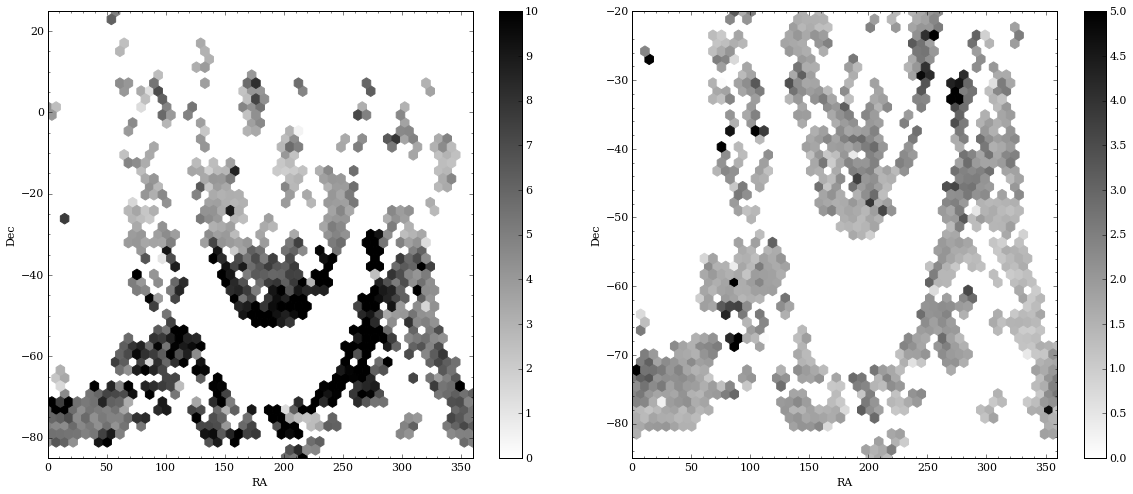

In [132]:
fig, test=plt.subplots(1,2, figsize=(20,8))
#ax=fig.add_subplot(211)
#ay=fig.add_subplot(212)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.1)

ax=master.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_up', ax=test[0], reduce_C_function=np.mean, gridsize=50, grid=None, vmin=0, vmax=10, cmap='binary')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.minorticks_on()
ax.grid(False)

ay=master.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_us', ax=test[1], reduce_C_function=np.mean, gridsize=50, grid=None, vmin=0, vmax=5, cmap='binary')
ay.set_xlabel('RA')
ay.set_ylabel('Dec')
ay.minorticks_on()
ay.grid(False)



imgname='pmquality_ucacppmxl_iraf.eps'
#plt.savefig(imgname)

#master.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_us', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs SPM', vmin=0, vmax=10)
#master.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_ps', reduce_C_function=np.mean, gridsize=50, title='PPMXL vs SPM', vmin=0, vmax=10)


Trim the sample down to targets that meet the proper motion quality criteria. Can see from colorbars that adding these criteria leads to a sample where the variation in the different surveys shrinks somewhat.

In [138]:
index=np.where((master.match==1) & (master.neighbor==0) & (master.nFit>=4) & (master.fitRA<=5) & (master.fitDec<=5))
clean=master.loc[index[0]]
print len(master), len(clean)

242420 179422


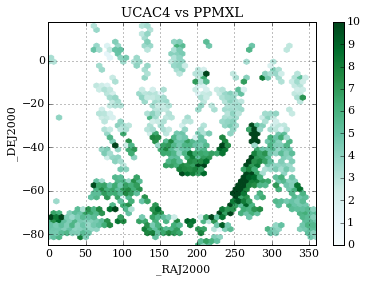

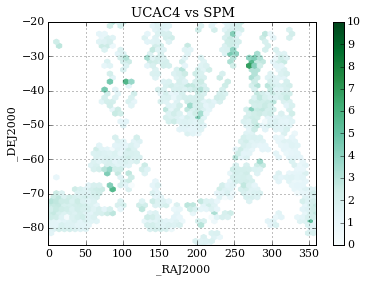

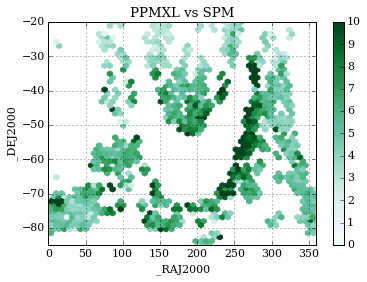

In [139]:
clean.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_up', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs PPMXL', vmin=0, vmax=10)
clean.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_us', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs SPM', vmin=0, vmax=10)
clean.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_ps', reduce_C_function=np.mean, gridsize=50, title='PPMXL vs SPM', vmin=0, vmax=10)


The median value doesn't shift much, but the standard deviation is smaller for the clean sample (although not quite for the UCAC4 vs. SPM....!). However, the distributions don't get markedly better with the trimming. Hmm!

In [140]:
print np.mean(np.abs(clean.diff_up)), np.mean(np.abs(master.diff_up))
print np.mean(np.abs(clean.diff_us)), np.mean(np.abs(master.diff_us))
print np.mean(np.abs(clean.diff_ps)), np.mean(np.abs(master.diff_ps))

print np.std(np.abs(clean.diff_up)), np.std(np.abs(master.diff_up))
print np.std(np.abs(clean.diff_us)), np.std(np.abs(master.diff_us))
print np.std(np.abs(clean.diff_ps)), np.std(np.abs(master.diff_ps))


5.38630782303 7.06011600126
1.97353414602 2.13688597203
5.9662192252 7.91182362512
8.50491715891 16.0108466961
2.67727956994 3.31948808346
9.04328055563 16.8854939591


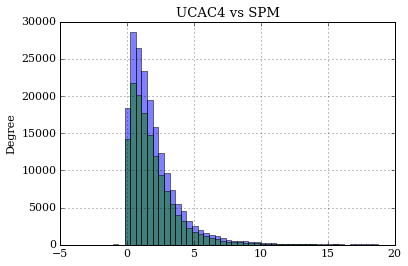

In [141]:
master['diff_us'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20], title="UCAC4 vs SPM")
clean['diff_us'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20])

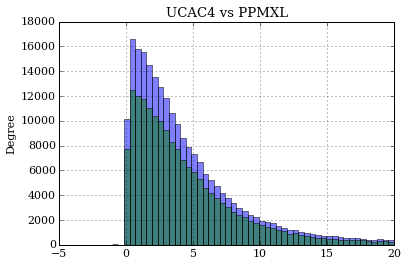

In [142]:
master['diff_up'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20], title="UCAC4 vs PPMXL")
clean['diff_up'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20])


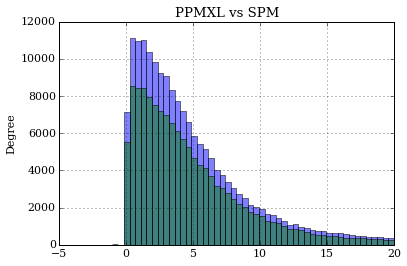

In [143]:
master['diff_ps'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20], title="PPMXL vs SPM")
clean['diff_ps'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20])


In [58]:
sdss=pd.read_csv("/Users/kschles/Documents/GALAH/propermotion/sdss_match_ups_10262015.csv")

In [62]:
sdss['diff_up']=abs(np.sqrt(np.power(sdss.u_pmRA,2)+np.power(sdss.u_pmDE,2))-np.sqrt(np.power(sdss.p_pmRA,2)+np.power(sdss.p_pmDE,2)))
sdss['diff_sdu']=abs(np.sqrt(np.power(sdss.pmRa,2)+np.power(sdss.pmDec,2))-np.sqrt(np.power(sdss.u_pmRA,2)+np.power(sdss.u_pmDE,2)))
sdss['diff_sdp']=abs(np.sqrt(np.power(sdss.pmRa,2)+np.power(sdss.pmDec,2))-np.sqrt(np.power(sdss.p_pmRA,2)+np.power(sdss.p_pmDE,2)))
#sdss['diff_us']=abs(np.sqrt(np.power(sdss.u_pmRA,2)+np.power(sdss.u_pmDE,2))-np.sqrt(np.power(sdss.s_pmRA,2)+np.power(sdss.s_pmDE,2)))
#sdss['diff_ps']=abs(np.sqrt(np.power(sdss.p_pmRA,2)+np.power(sdss.p_pmDE,2))-np.sqrt(np.power(sdss.s_pmRA,2)+np.power(sdss.s_pmDE,2)))

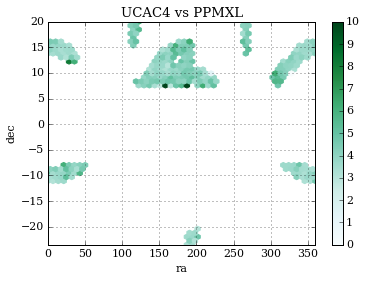

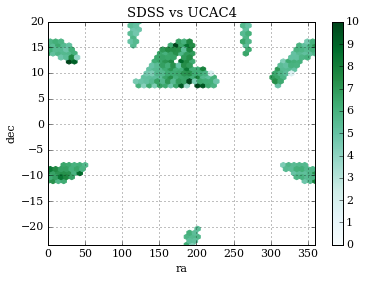

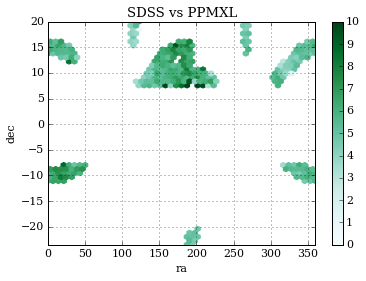

In [63]:
sdss.plot(kind='hexbin', x='ra',y='dec', C='diff_up', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs PPMXL', vmin=0, vmax=10)
sdss.plot(kind='hexbin', x='ra',y='dec', C='diff_sdu', reduce_C_function=np.mean, gridsize=50, title='SDSS vs UCAC4', vmin=0, vmax=10)
sdss.plot(kind='hexbin', x='ra',y='dec', C='diff_sdp', reduce_C_function=np.mean, gridsize=50, title='SDSS vs PPMXL', vmin=0, vmax=10)
#sdss.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_us', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs SPM', vmin=0, vmax=10)
#sdss.plot(kind='hexbin', x='_RAJ2000',y='_DEJ2000', C='diff_ps', reduce_C_function=np.mean, gridsize=50, title='PPMXL vs SPM', vmin=0, vmax=10)


In [34]:
print sdss.columns.values
print len(sdss)

['ra' 'dec' 'delta' 'match' 'pmL' 'pmB' 'pmRa' 'pmDec' 'pmRaErr' 'pmDecErr'
 'sigRa' 'sigDec' 'nFit' 'O' 'E' 'J' 'F' 'N' 'dist20' 'dist22' 'objid'
 'psfMag_u' 'psfMag_g' 'psfMag_r' 'psfMag_i' 'psfMag_z' 'V' 'UCAC4'
 'u_pmRA' 'u_pmDE' 'ue_pmRA' 'ue_pmDE' 'PPMXL_ID' 'p_pmRA' 'p_pmDE'
 'pe_pmRA' 'pe_pmDE' 'diff_up' 'diff_sdu']
542599


In [64]:
index=np.where((sdss.match==1) & (sdss.dist22>=7) & (sdss.nFit>=4) & (sdss.sigRa<=500) & (sdss.sigDec<=500))
clean=sdss.loc[index[0]]
print len(sdss), len(clean)

542599 437943


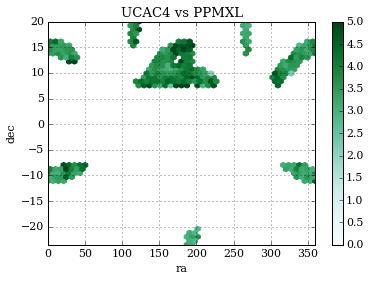

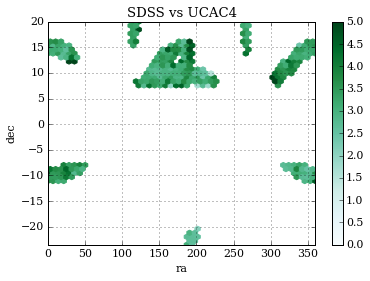

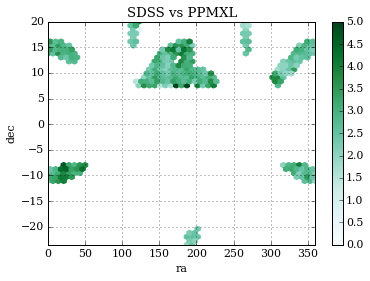

In [68]:
clean.plot(kind='hexbin', x='ra',y='dec', C='diff_up', reduce_C_function=np.mean, gridsize=50, title='UCAC4 vs PPMXL', vmin=0, vmax=5)
clean.plot(kind='hexbin', x='ra',y='dec', C='diff_sdu', reduce_C_function=np.mean, gridsize=50, title='SDSS vs UCAC4', vmin=0, vmax=5)
clean.plot(kind='hexbin', x='ra',y='dec', C='diff_sdp', reduce_C_function=np.mean, gridsize=50, title='SDSS vs PPMXL', vmin=0, vmax=5)


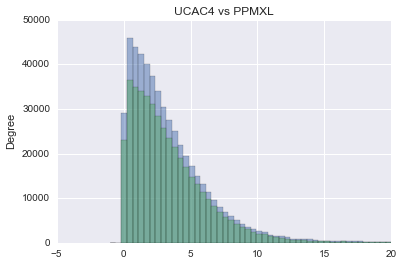

In [37]:
sdss['diff_up'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20], title="UCAC4 vs PPMXL")
clean['diff_up'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20])


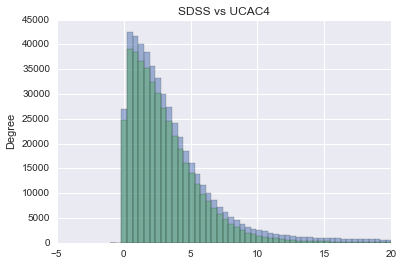

In [38]:
sdss['diff_sdu'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20], title="SDSS vs UCAC4")
clean['diff_sdu'].plot(kind='hist', alpha=0.5, bins=50, range=[-1,20])


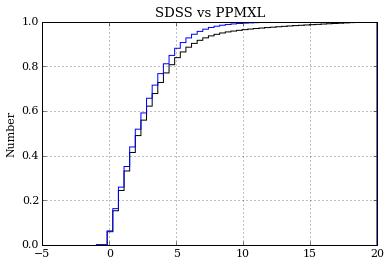

In [81]:
sdss['diff_sdp'].plot(kind='hist', alpha=1.0, bins=50, range=[-1,20], title="SDSS vs PPMXL", color='k', histtype='step', normed=True, cumulative=True)
clean['diff_sdp'].plot(kind='hist', alpha=1.0, bins=50, range=[-1,20], normed=True, cumulative=True, histtype='step')
plt.ylabel('Number')
